# Part 3: Peer-to-peer Message Behaviour Data Analysis

---

### Install Python packages (pip only)

In [8]:
%pip install networkx ndlib



Note: you may need to restart the kernel to use updated packages.


You should consider upgrading via the 'C:\Users\HSR\AppData\Local\Microsoft\WindowsApps\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\python.exe -m pip install --upgrade pip' command.


### Import Python packages

In [9]:
import networkx as nx
import pandas as pd
import datetime
import csv
import operator
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline 
plt.rcParams['figure.figsize'] = (4.0, 2.0)
import numpy as np
import operator
import random

import ndlib.models.ModelConfig as mc
import ndlib.models.epidemics as ep
import ndlib.models.CompositeModel as gc
import ndlib.models.compartments as cs
from ndlib.utils import multi_runs
from ndlib.viz.mpl.DiffusionTrend import DiffusionTrend

---

### Task 1 of 2

Examine the file "p2p_msg_cmt224.csv" which represents messaging behaviour between users on a messaging platform. Each row has four columns, representing a single event where a person (person_a) messaged another person (person_b) on some date (date) at some time of day (time). From this, answer the following questions:

##### Q1. Build a suitable network to represent social connections based on the messaging behaviour that took place up to and including the first day of May. In doing so, assume that one or more messages from one person to another represents a MUTUAL underlying social connection (i.e., regardless of whether person_a messaged person_b, vice versa, or both). 

##### What non-existent edges would need to be added to the network such that a message could pass along a path from any node to any other? In doing so, aim to minimise the longest shortest path in the network.

In [10]:
#CODE:
output_rows = []
with open('p2p_msg_cmt224.csv', newline='') as f:
    reader = csv.reader(f)
    headers = next(reader)
    for row in reader:
        row[0] = int(row[0])
        row[1] = int(row[1])
        row[2] = datetime.datetime.strptime(row[2], "%d/%m/%Y").date()

        if (row[2] <=datetime.datetime.strptime('01/05/2004', "%d/%m/%Y").date()):
            output_rows.append(row)

# Write out a new csv (if required)

df = pd.DataFrame(output_rows,columns=['person_a','person_b','date','time'])
mygraph = nx.from_pandas_edgelist(df,source='person_a',target='person_b',edge_attr=['date','time'], create_using=nx.Graph)
connectedcomp = sorted(nx.connected_components(mygraph))
print(sorted([(node[0],node[1]) for node in nx.degree_centrality(mygraph).items()], key=operator.itemgetter(1), reverse =True)[0])

#print(nx.is_connected(mygraph))
mygraph.add_edge(230,41)
mygraph.add_edge(426,41)
mygraph.add_edge(433,41)

#print(nx.is_connected(mygraph))
print ('longest shortest path: ', nx.diameter(mygraph))

#df


(41, 0.15837937384898712)
longest shortest path:  7


##### Q2. Build a suitable network to represent social connections based on the cumulation of ALL message behaviour in the dataset. In doing so, assume that one or messages from one person to another represents a MUTUAL underlying social connection (i.e., regardless of whether person_a messaged person_b, vice versa, or both).

##### Can the social phenomenon, ‘Triadic Closure’, be supported for the COMMON nodes that exist in both the network created from data up to and including the first day of May (i.e., from Task 1, Q1) and the cumulative network?

In [11]:
#CODE:
messagingCSV = pd.read_csv('p2p_msg_cmt224.csv')
msgGraph = nx.from_pandas_edgelist(messagingCSV,source='person_a',target='person_b',edge_attr=['date','time'], create_using=nx.Graph)
print('Transitivity of the messages graph up to may: ','%0.3f' %nx.transitivity(mygraph))
print('Transitivity of all the messages graph: ', '%0.3f' %nx.transitivity((msgGraph.subgraph(mygraph.nodes()))))


Transitivity of the messages graph up to may:  0.048
Transitivity of all the messages graph:  0.086


##### Q3. Using the largest connected component of the cumulative network constructed in Task 1, Q2, what is the average and standard deviation of the MAXIMUM degree of separation between an individual and all others?

In [12]:
#CODE:
largestconnectedcomponent = sorted(nx.connected_components(msgGraph), key = len,reverse=True)[0]
lccSub = msgGraph.subgraph(largestconnectedcomponent).copy()

subEccentricity = list(nx.eccentricity(lccSub).values())

print('Average eccentricty of the largest connected compoenent sub-graph: ', '%0.2f' %np.mean(subEccentricity))
print('Standard deviation of the largest connected componenet sub-graph: ', '%0.2f' %np.std(subEccentricity))


Average eccentricty of the largest connected compoenent sub-graph:  5.53
Standard deviation of the largest connected componenet sub-graph:  0.57


### Task 2 of 2 

Using the largest connected component of the cumulative social network constructed in Task 1, Q2, assume the role of an outsider with complete visibility of the network that now wishes to spread a hypothetical message such that everyone in the component would know the information it contained as quickly as possible. 

Assume that messages will now spread in sequential timesteps using the following mechanism. If an individual is told the message at timestep 𝑡, the individual will forward the message to all of their direct connections at timestep 𝑡+1. Individuals can therefore be told the message more than once. From this, answer the following questions:

##### Q1. If you could only select 1 individual to tell at timestep 0, what nodes could you select which would result in the message being received by everyone in the fewest timesteps as possible and what would the number of timesteps be?

Initial infected node using closeness centrality is :  [32]

Threshold met = True after 4 iterations.


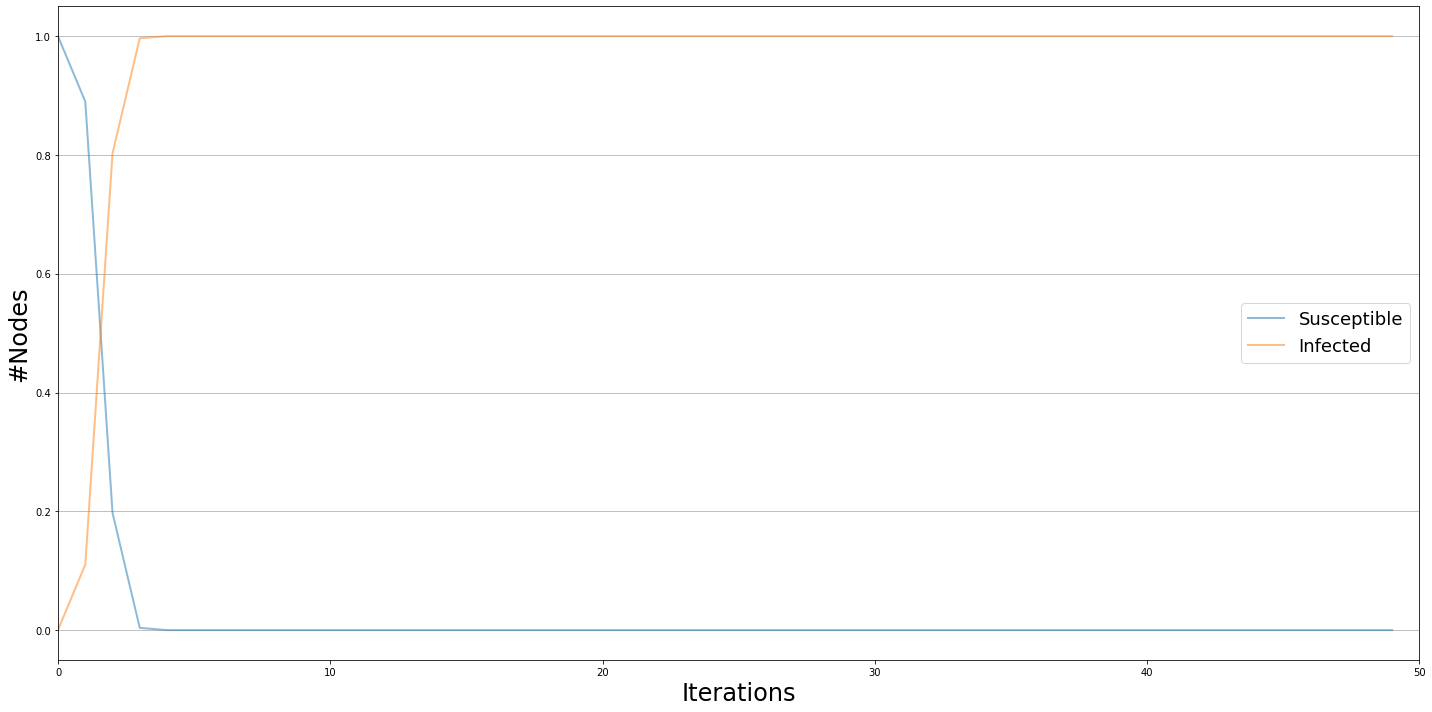

In [13]:
#CODE:

def runSIModelOnANetwork(G, b, i, initial_infected=None, fraction_infected=None, model_seed=1):

    model = ep.SIModel(G, seed=model_seed)
    model_configuration = mc.Configuration()

    model_configuration.add_model_parameter('beta', b)

    if initial_infected is not None:
        model_configuration.add_model_initial_configuration("Infected", initial_infected)
    else:
        model_configuration.add_model_parameter("fraction_infected", fraction_infected) 
        
    model.set_initial_status(model_configuration)
    iterations = model.iteration_bunch(i)
    
    return model, iterations

def evaluateModel(network, model, trends, threshold):
    
    trends = model.build_trends(iterations)

    diffusion_trend = DiffusionTrend(model, trends)

    results = calculate_iterations_to_reach_threshold( 
        trends,
        network.number_of_nodes(),
        threshold,
        False
    )
    
    return diffusion_trend, results


def calculate_iterations_to_reach_threshold(trends, number_of_nodes, threshold, verbose=False):
    threshold_as_number_of_nodes = (number_of_nodes*threshold)
    
    iteration_counts_per_simulation = []
    
  
    for simulation in trends:
        
        number_infected_per_iteration = simulation["trends"]["node_count"][1]
        
  
        threshold_met = False
        iteration_count = 0
        for iteration, number_infected in enumerate(number_infected_per_iteration):
           
            if verbose:
                print("Iteration: %s     Number infected: %d     (%.2f)" % (iteration, number_infected, number_infected / number_of_nodes))
            
            if number_infected < threshold_as_number_of_nodes:
                threshold_met = True
                iteration_count += 1
            else:
                break
                
            
            
        iteration_counts_per_simulation.append((threshold_met, iteration_count))
        
    return iteration_counts_per_simulation



network = lccSub                    # Set the network to be used, in this case the NetworkX Graph object, G

beta = 1.0                   # Set the global probability of "infection"/information spreading
number_of_iterations = 50      # Set the number of iterations

k = 1            # Set the number of nodes to be the initial "infected"/sources of the information

s = 200                         # Set the random seed for the model to use

evaluation_threshold = 1.0000000

degree_centrality = sorted(
    [(node[0], node[1]) for node in nx.degree_centrality(lccSub).items()], 
    key=operator.itemgetter(1), 
    reverse=True
)

closeness_centrality = sorted(
    [(node[0], node[1]) for node in nx.closeness_centrality(lccSub).items()], 
    key=operator.itemgetter(1), 
    reverse=True
)

betweenness_centrality = sorted(
    [(node[0], node[1]) for node in nx.betweenness_centrality(lccSub).items()], 
    key=operator.itemgetter(1), 
    reverse=True
)
initial_infected_nodes = [node[0] for node in closeness_centrality[:k]]

model, iterations = runSIModelOnANetwork( 
    network,
    beta,
    number_of_iterations,
    initial_infected = initial_infected_nodes,
    model_seed = s
)

diffusion_trend, threshold_analysis = evaluateModel(
    network,
    model, 
    iterations, 
    evaluation_threshold,
)




print('Initial infected node using closeness centrality is : ' , (initial_infected_nodes)) # Print our the initial nodes used
print("\nThreshold met = %s after %i iterations." % (threshold_analysis[0][0], threshold_analysis[0][1]))

diffusion_trend.plot()
plt.show()


##### Q2. If you had to select any 5 individuals to tell at timestep 0, what is an example set of individuals that would result in the message being received by everyone in fewer timesteps than the single individual selection in Q1? In determining your answer, use an appropriate network connectivity measure for each node, rather than an exhaustive search through every combination.

Initial infected nodes using closeness centrality are :  [32, 105, 9, 3, 638]

Threshold met = True after 4 iterations.


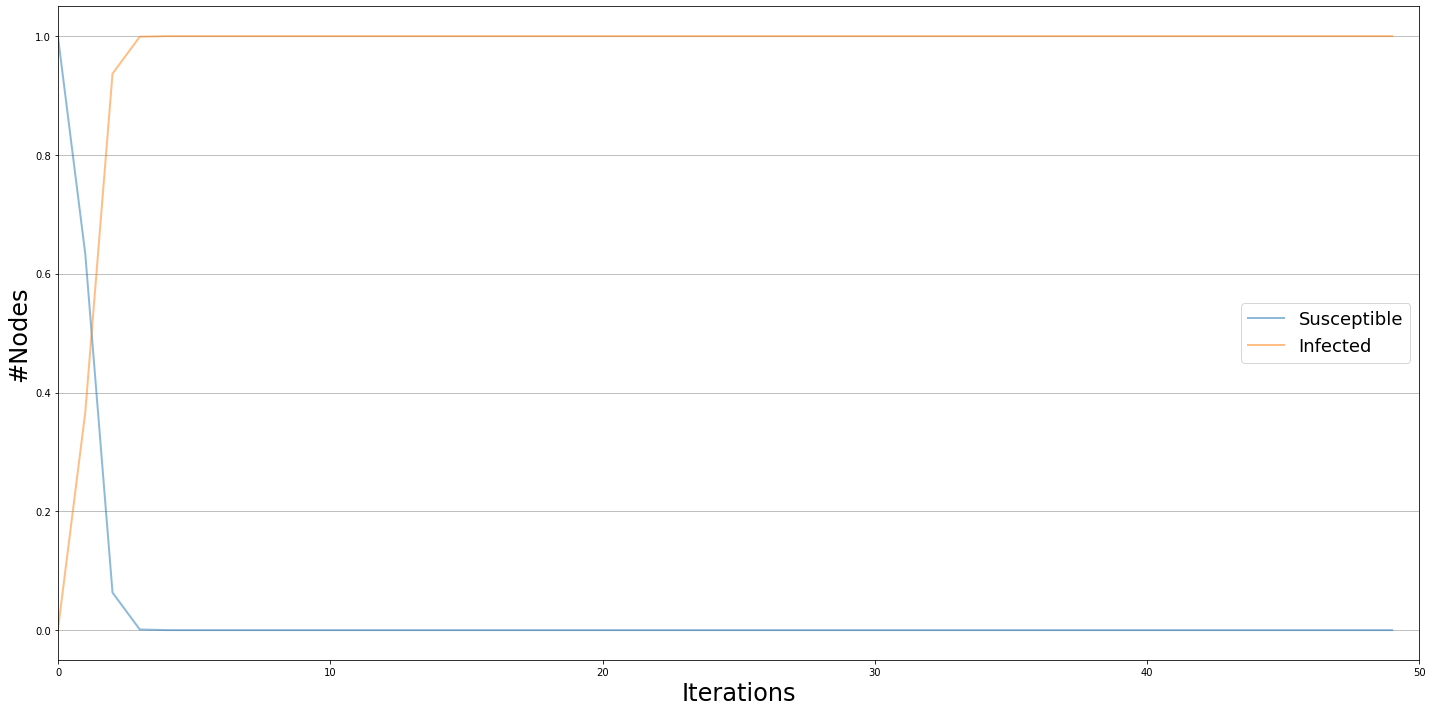

In [14]:
#CODE:

network = lccSub                    # Set the network to be used, in this case the NetworkX Graph object, G

beta = 1.0                   # Set the global probability of "infection"/information spreading
number_of_iterations = 50      # Set the number of iterations

k = 5           # Set the number of nodes to be the initial "infected"/sources of the information

s = 200                         # Set the random seed for the model to use

evaluation_threshold = 1.0000000

degree_centrality = sorted(
    [(node[0], node[1]) for node in nx.degree_centrality(lccSub).items()], 
    key=operator.itemgetter(1), 
    reverse=True
)

closeness_centrality = sorted(
    [(node[0], node[1]) for node in nx.closeness_centrality(lccSub).items()], 
    key=operator.itemgetter(1), 
    reverse=True
)

betweenness_centrality = sorted(
    [(node[0], node[1]) for node in nx.betweenness_centrality(lccSub).items()], 
    key=operator.itemgetter(1), 
    reverse=True
)
initial_infected_nodes = [node[0] for node in closeness_centrality[:k]]

model, iterations = runSIModelOnANetwork( # Configure and run the model using the method created earlier
    network,
    beta,
    number_of_iterations,
    initial_infected = initial_infected_nodes,
    model_seed = s
)

diffusion_trend, threshold_analysis = evaluateModel(
    network,
    model, 
    iterations, 
    evaluation_threshold,
)




print('Initial infected nodes using closeness centrality are : ', (initial_infected_nodes)) # Print our the initial nodes used
print("\nThreshold met = %s after %i iterations." % (threshold_analysis[0][0], threshold_analysis[0][1]))

diffusion_trend.plot()
plt.show()